## Breast cancer dataset

The data set That I will be using is gathered from kaggle.
link: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download

The information is composed of A digitized image of a fine needle aspirate (FNA) of a breast mass is used to compute features. They describe the properties of the cell nuclei depicted in the image.

For clustering the data based on the features provided of PCA and t_SNE.
reason are the PCA is advantageous for linear dimensionality reduction, feature selection, and noise reduction, while t-SNE excels in capturing non-linear relationships, visualizing clusters, and preserving local structure. The choice between PCA and t-SNE depends on the specific goals of the analysis and the characteristics of the dataset.

In [37]:
# needed modules
import pandas as pd
from sklearn.decomposition import PCA
import yaml
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns 


The data can now be loaded into the system using yaml and safe_load.

In [38]:
# load the data in with the config file
with open("config.yml") as config:
    input_files = yaml.safe_load(config)
    df = pd.read_csv(input_files["cancer"])

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Data inspectation
Now we can show the matrix's form and count the amount of NAN values.
If we are going to apply PCA, NAN values are not allowed. As a result, these must be removed or replaced.
Also, the data type should all be A float or an integer. This should also be verified.

In [39]:
amount_na= {} # capture the amount of NAN values 
print(f"columns in the dataframe: {df.shape[1]}. Amount of rows: {df.shape[0]}.")
# df.dtypes # This section is commented out due to the clutter it generates when run.
for col in df.columns:
    found_nan = df[col].isna().sum()
    if found_nan > 0:
        amount_na[col] = df[col].isna().sum()
sorted_amount_na = sorted(amount_na.items(), key=lambda x:x[1], reverse=True)
print(f"the amount of NAN values found in the column: {sorted_amount_na}")

columns in the dataframe: 32. Amount of rows: 569.
the amount of NAN values found in the column: []


## Extra checks

So the data is correct, and there are no NAN values.
The data distribution is then examined. Although not required for PCA, knowing how the data is distributed is useful.
also we need to Assess the correlation structure of the variables before applying PCA. High correlations between variables can impact the effectiveness of PCA, potentially leading to unstable or less interpretable results. We are going to Remove or combin highly correlated variables to improve the performance of PCA.

In [40]:
# makes it easier to plot
df_B = df.loc[df["diagnosis"] == "B"]
df_B = df_B.drop(columns=["id","diagnosis"]) 
df_M = df.loc[df["diagnosis"] == "M"]
df_M = df_M.drop(columns=["id","diagnosis"]) 

### Normal distribution.

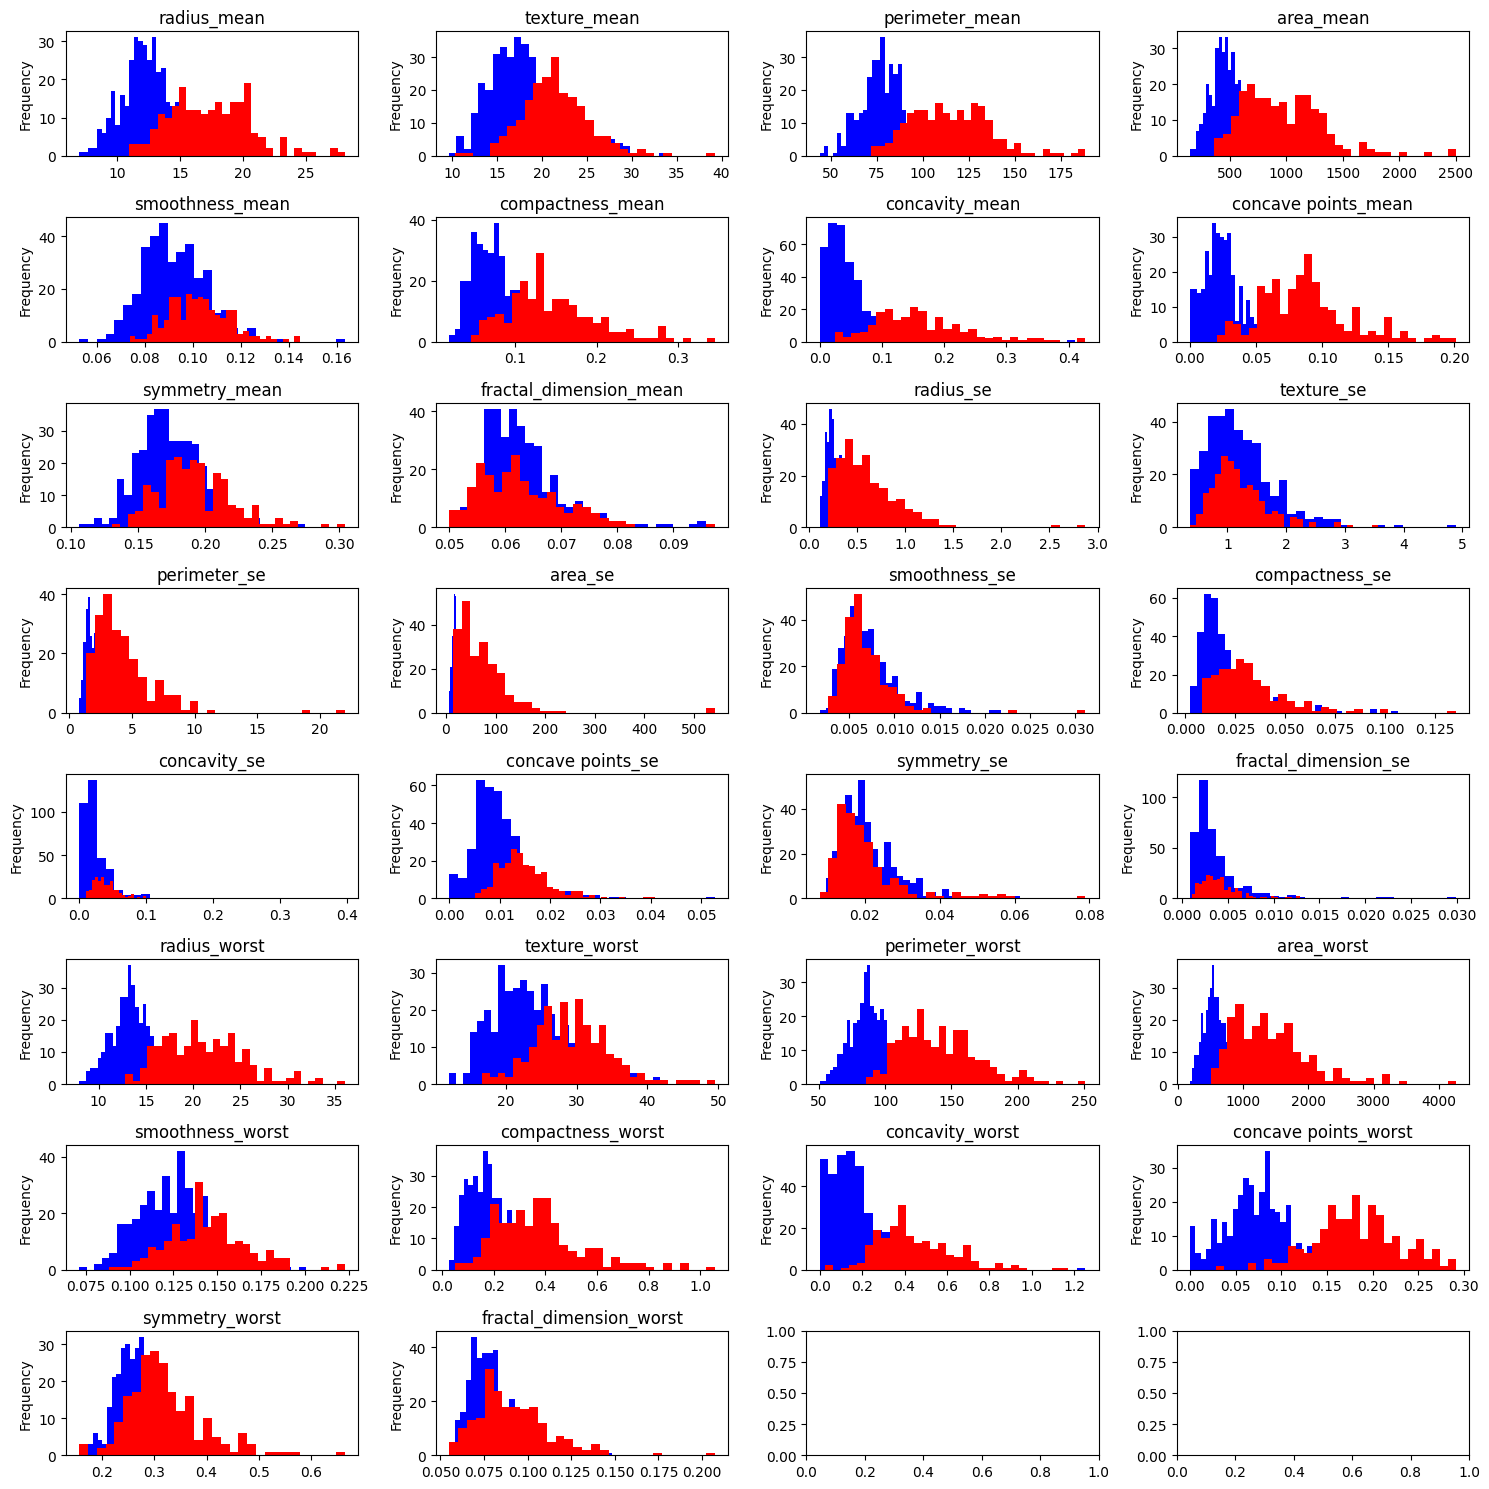

In [41]:
# check if the data is normally distributed.
num_cols = 4  # Number of columns in the grid
num_rows = (df.shape[1] - 1) // num_cols + 1  # Number of rows in the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15)) # figures that we gonna fill in with histograms

axes = axes.flatten()
for i, col in enumerate(df_M.columns):
    ax = axes[i]  # Get the current axis
    df_B[col].plot(kind='hist', ax=ax, bins=30,color = "blue")
    df_M[col].plot(kind='hist', ax=ax, bins=30,color = "red")   # Plot the histogram for the current column
    ax.set_title(col)  # Set the title for the subplot
plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

### correlation
It appears to be in order, so let us now look at the relationship between the columns.
The correlation will be plotted in a grid with only the correlation coefficient because that is what is important.
So, in order to produce the best PCA possible, we must delete the rows with strong correlation.


<Axes: >

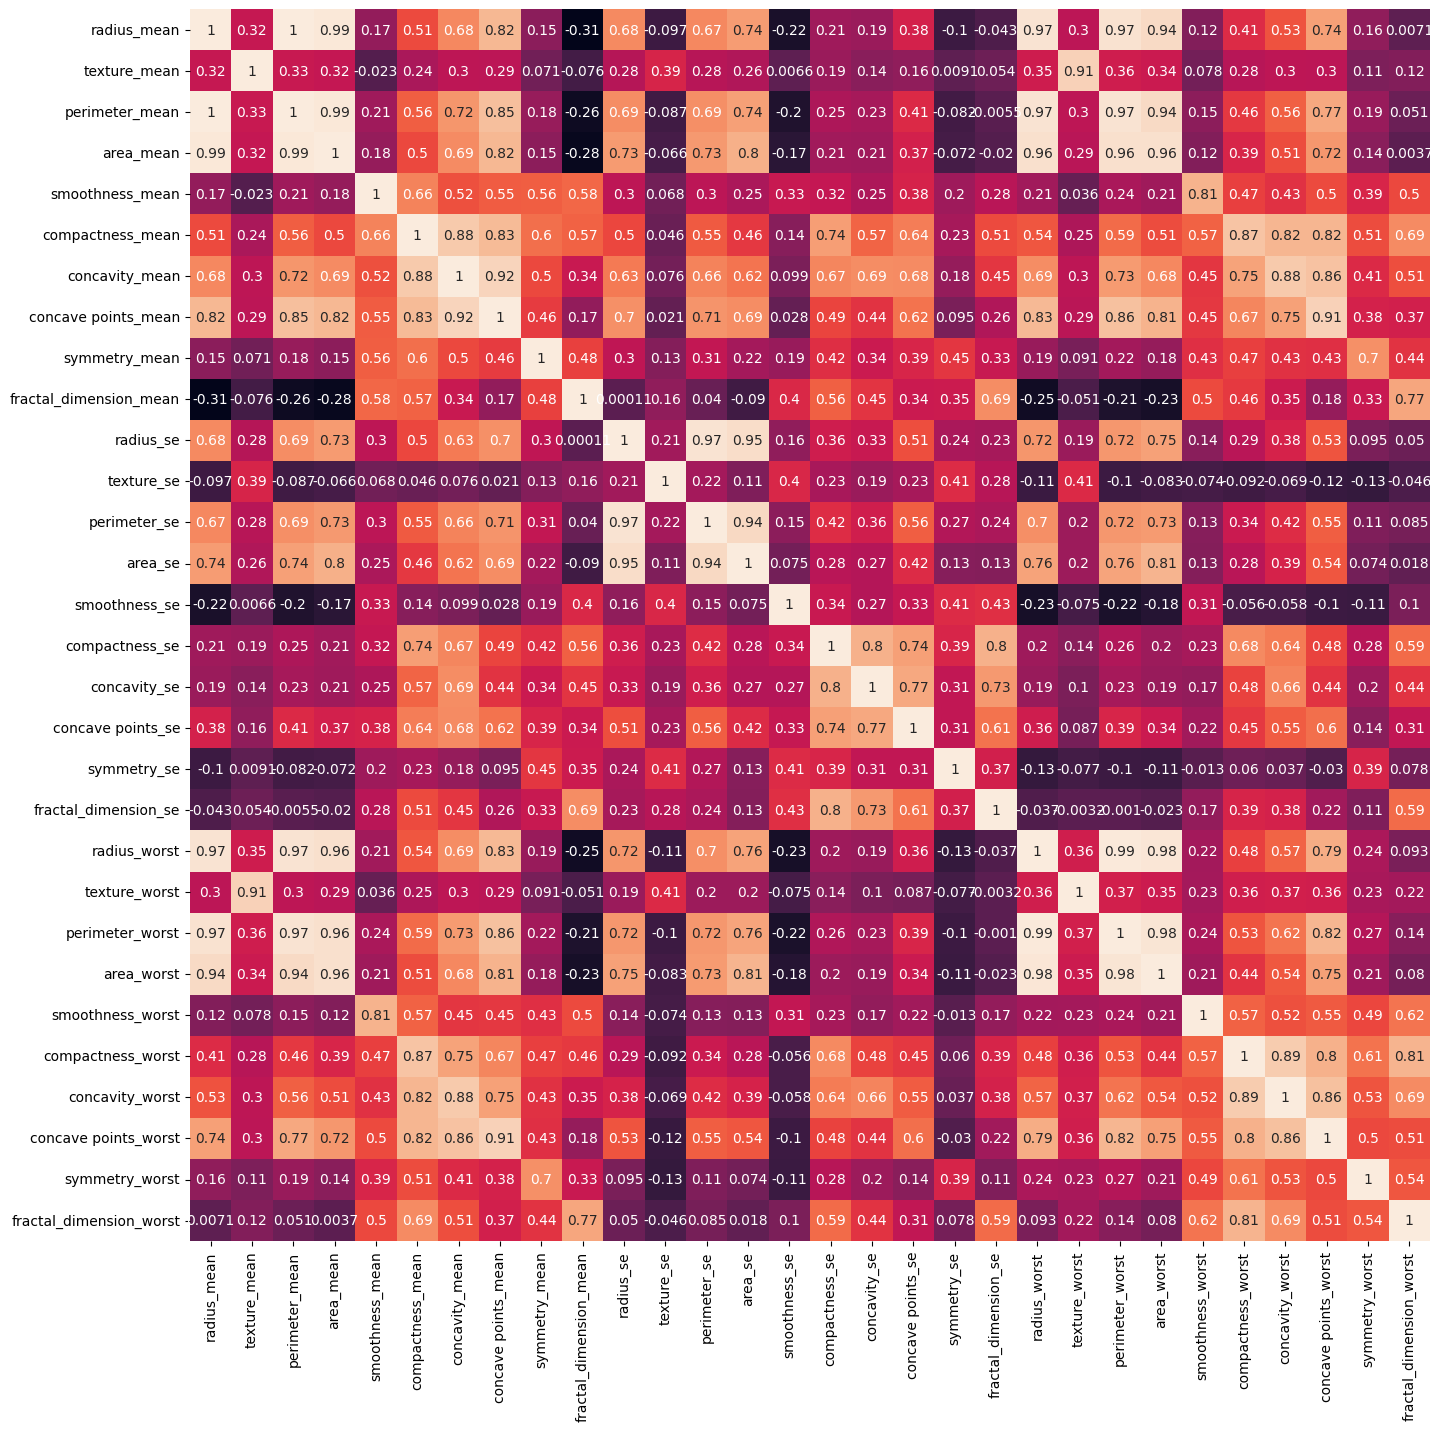

In [42]:
# showing correlation with an R
plt.figure(figsize=(16, 16))
df_cor = df.drop(columns=["id","diagnosis"])
matrix = df_cor.corr()
sns.heatmap(matrix,annot=True,cbar=False)

As seen in the plot, the following columns must be removed: area_mean, radius_worst, perimeter_worst, area_worst, and perimeter_mean.
There are many more that are highly connected, but for the time being, I will focus on the ones that are greater than 90 percent.

In [43]:
# the data for the PCA first we need to scale the data for use.
scaler = StandardScaler()
X = df.drop(columns=["id","diagnosis","area_mean","radius_worst","perimeter_worst","area_worst","perimeter_mean"])
X = scaler.fit_transform(X)
y = list(df["diagnosis"])

# clustering
We can now cluster the data using PCA and t_SNE, and because both techniques are strong, I expect the clustering to perform better than using simply PCA or t_SNE. 


In [45]:
# fitting the PCA and then the t_SNE to make use of both techniques
pca = PCA()
pc = pca.fit_transform(X)

In [47]:
#initiate instance
X_embedded = TSNE(n_components=2, learning_rate='auto', random_state = 42, init='random')
#fit 
X_embedded = X_embedded.fit_transform(pc)
# produced an two dimension array with x,y features for every row, since n_components = 2
X_embedded.shape

(569, 2)

Let's create a pandas data frame with these values and replace the labels.


In [51]:
dataframe_results = pd.DataFrame(data =X_embedded,columns=["demention_1","demention_2"])
dataframe_results["types"] = y

# Plotting

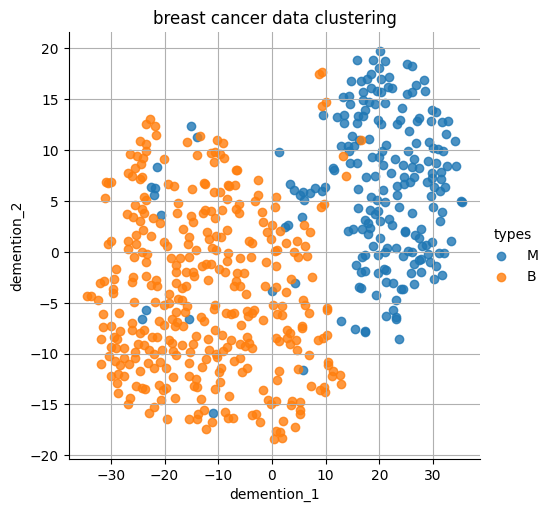

In [52]:
# plot the TSNE data 
sns.lmplot(
    x='demention_1', 
    y='demention_2', 
    data=dataframe_results, 
    hue='types', 
    fit_reg=False, 
    legend=True
    )
 
plt.title('breast cancer data clustering')
plt.grid()
plt.show()

# conclusion
The techniques work, but they are not perfect. As seen in the plot, some of the malignant type cluster with the other dots. This could be because the features are related. 
For this type of data, a PCA or t_SNE may be sufficient. 